# Forecast Model Run Collections (FMRC) with a custom Xarray Index

There are many ways one might index weather forecast output. These different ways of constructing views of a forecast data are called "Forecast Model Run Collections" (FMRC).
- "Model Run" : a single model run.
- "Constant Offset" : all values for a given lead time.
- "Constant Forecast" : all forecasts for a given time in the future.
- "Best Estimate" : A best guess stitching together the analysis or initialization fields for past forecasts with the latest forecast.

For reference, see [this classic image](https://www.unidata.ucar.edu/presentations/caron/FmrcPoster.pdf).

Assume that a data cube has been constructed with `forecast_reference_time` (commonly `time`) and `forecast_period` (commonly `step` or `lead`) as dimensions.


Then the more complex indexing patterns --- "Constant Forecast" or "Best Estimate" --- are easily achievable with numpy-style vectorized indexing.
This notebook demonstrates all 4 "FMRC" indexing patterns with a custom Xarray index.


Some complexity arises from models like HRRR where not all runs are the same length (unlike GFS).
This complexity is handled by hardcoding in what data is available for each model: for example, with HRRR we know there are 49 `step`s available every 6 hours, and 19 `steps` otherwise.

In [1]:
from forecast_index import (
    BestEstimate,
    ConstantForecast,
    ConstantOffset,
    ForecastIndex,
    Model,
    ModelRun,
)

## Create an example data cube

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

xr.set_options(keep_attrs=True)

ds = xr.Dataset(attrs={"description": "Example HRRR-like dataset"})
shape = {"x": 40, "time": 60, "step": 49}
ds["foo"] = (("x", "time", "step"), np.ones(tuple(shape.values())))
ds["time"] = (
    "time",
    pd.date_range("2024-05-01", freq="h", periods=shape["time"]),
    {"standard_name": "forecast_reference_time"},
)
ds["step"] = (
    "step",
    pd.to_timedelta(np.arange(0, 49), unit="hours"),
    {"standard_name": "forecast_period"},
)

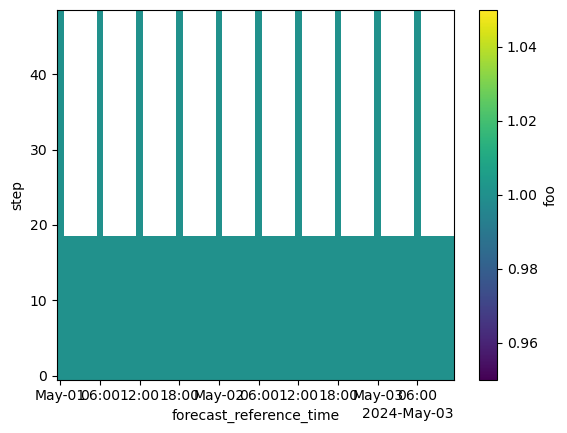

In [3]:
ds["foo"] = xr.where(
    ~((ds.time.dt.hour % 6 != 0) & (ds.step.dt.total_seconds() / 3600 > 18)),
    ds.foo,
    np.nan,
)
ds.foo.isel(x=20).drop_vars("step").plot(x="time")

## Create a ForecastIndex

In [4]:
# Add a dummy variable to enable nice indexing syntax 
# e.g. `.sel(forecast=ConstantForecast('2024-05-22'))`
ds.coords["forecast"] = 0

# set the new index
newds = ds.drop_indexes(["time", "step"]).set_xindex(
    ["time", "step", "forecast"], ForecastIndex, model=Model.HRRR
)
newds

<xarray.Dataset> Size: 942kB
Dimensions:   (time: 60, step: 49, x: 40)
Coordinates:
  * time      (time) datetime64[ns] 480B 2024-05-01 ... 2024-05-03T11:00:00
  * step      (step) timedelta64[ns] 392B 00:00:00 01:00:00 ... 2 days 00:00:00
  * forecast  int64 8B 0
Dimensions without coordinates: x
Data variables:
    foo       (time, step, x) float64 941kB 1.0 1.0 1.0 1.0 ... nan nan nan nan
Indexes:
  ┌ time      ForecastIndex
  │ step
  └ forecast
Attributes:
    description:  Example HRRR-like dataset

## "Standard" selection

In [5]:
newds.sel(time=slice("2024-05-03", None), step=slice("2h", "12h"))

<xarray.Dataset> Size: 42kB
Dimensions:   (time: 12, step: 11, x: 40)
Coordinates:
  * time      (time) datetime64[ns] 96B 2024-05-03 ... 2024-05-03T11:00:00
  * step      (step) timedelta64[ns] 88B 02:00:00 03:00:00 ... 11:00:00 12:00:00
  * forecast  int64 8B 0
Dimensions without coordinates: x
Data variables:
    foo       (time, step, x) float64 42kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Indexes:
  ┌ forecast  ForecastIndex
  │ time
  └ step
Attributes:
    description:  Example HRRR-like dataset

## FMRC indexing

For all cases, the index knows how to select values so there are no NaNs i.e. it only tries to pull out valid data! 
We've told it this is HRRR, and the HRRR output characteristics are hard-coded in the index. This could be refactored a little.

Other models, like GFS, don't require any configuration.


### `BestEstimate`

In [6]:
subset = newds.sel(forecast=BestEstimate())
assert not subset.foo.isnull().any().item()
subset

<xarray.Dataset> Size: 27kB
Dimensions:     (valid_time: 78, x: 40)
Coordinates:
    time        (valid_time) datetime64[ns] 624B 2024-05-01 ... 2024-05-03T11...
    step        (valid_time) timedelta64[ns] 624B 00:00:00 00:00:00 ... 18:00:00
  * valid_time  (valid_time) datetime64[ns] 624B 2024-05-01 ... 2024-05-04T05...
Dimensions without coordinates: x
Data variables:
    foo         (valid_time, x) float64 25kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    description:  Example HRRR-like dataset

### `ConstantForecast`

**TODO:** Adding a scalar `valid_time` for `ConstantForecast` triggers a bug.

In [7]:
subset = newds.sel(forecast=ConstantForecast("2024-05-03"))
assert not subset.foo.isnull().any().item()
subset

<xarray.Dataset> Size: 7kB
Dimensions:  (time: 20, x: 40)
Coordinates:
  * time     (time) datetime64[ns] 160B 2024-05-01T06:00:00 ... 2024-05-03
    step     (time) timedelta64[ns] 160B 1 days 18:00:00 ... 00:00:00
Dimensions without coordinates: x
Data variables:
    foo      (time, x) float64 6kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    description:  Example HRRR-like dataset

### `ConstantOffset`

In [8]:
subset = newds.sel(forecast=ConstantOffset("32h"))
assert not subset.foo.isnull().any().item()
subset

<xarray.Dataset> Size: 3kB
Dimensions:     (time: 10, x: 40)
Coordinates:
  * time        (time) datetime64[ns] 80B 2024-05-01 ... 2024-05-03T06:00:00
    step        timedelta64[ns] 8B 1 days 08:00:00
  * valid_time  (time) datetime64[ns] 80B 2024-05-02T08:00:00 ... 2024-05-04T...
Dimensions without coordinates: x
Data variables:
    foo         (time, x) float64 3kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    description:  Example HRRR-like dataset

### `ModelRun`

In [9]:
subset = newds.sel(forecast=ModelRun("2024-05-03 03:00"))  # 19
assert subset.sizes["step"] == 19
subset

<xarray.Dataset> Size: 6kB
Dimensions:     (step: 19, x: 40)
Coordinates:
    time        datetime64[ns] 8B 2024-05-03T03:00:00
  * step        (step) timedelta64[ns] 152B 00:00:00 01:00:00 ... 18:00:00
  * valid_time  (step) datetime64[ns] 152B 2024-05-03T03:00:00 ... 2024-05-03...
Dimensions without coordinates: x
Data variables:
    foo         (step, x) float64 6kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    description:  Example HRRR-like dataset

In [10]:
subset = newds.sel(forecast=ModelRun("2024-05-03 06:00"))  # 49
assert subset.sizes["step"] == 49
subset

<xarray.Dataset> Size: 16kB
Dimensions:     (step: 49, x: 40)
Coordinates:
    time        datetime64[ns] 8B 2024-05-03T06:00:00
  * step        (step) timedelta64[ns] 392B 00:00:00 ... 2 days 00:00:00
  * valid_time  (step) datetime64[ns] 392B 2024-05-03T06:00:00 ... 2024-05-05...
Dimensions without coordinates: x
Data variables:
    foo         (step, x) float64 16kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    description:  Example HRRR-like dataset